# Section Alignment to Reference 

In [1]:
import sys
sys.path.insert(0,'../') # add code directory to path
# import lddmm
import torch_lddmm
# import numpy
import numpy as np
# import nibabel for i/o
import nibabel as nib
# import matplotlib for display
import matplotlib.pyplot as plt
import torch

# set device = 'cuda:#' to select GPU, or device = 'cpu' for CPU
device='cuda:0'

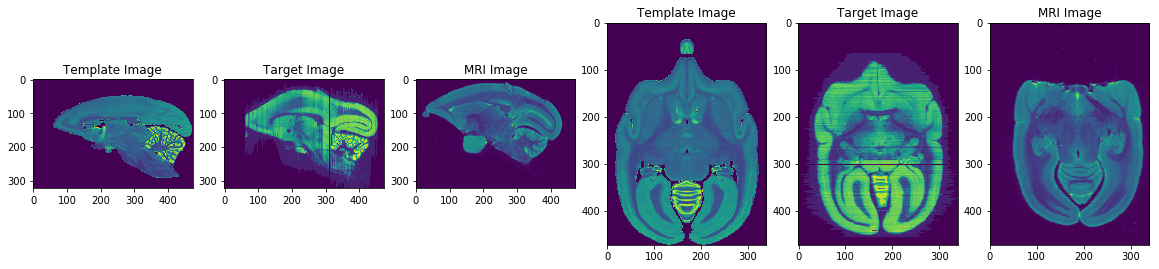

In [2]:
# load marmoset brain histology images
template_file_name = '../notebook/marmoset_atlas.img'
target_file_name = '../notebook/marmoset_target.img'
mri_file_name = '../notebook/marmoset_mri.img'

template_image_struct = nib.load(template_file_name)
target_image_struct = nib.load(target_file_name)
mri_image_struct = nib.load(mri_file_name)
dx = target_image_struct.header['pixdim'][1:4]

# load into numpy arrays
template_image = np.squeeze(template_image_struct.get_data()).astype(np.float32)
target_image = np.squeeze(target_image_struct.get_data()).astype(np.float32)
mri_image = np.squeeze(mri_image_struct.get_data()).astype(np.float32)

# display slices
plt.rcParams["figure.figsize"]=20,20
plt.figure()
plt.subplot(1,6,1)
plt.imshow(template_image[:,:,150])
plt.title('Template Image')
plt.subplot(1,6,2)
plt.imshow(target_image[:,:,150])
plt.title('Target Image')
plt.subplot(1,6,3)
plt.imshow(mri_image[:,:,150])
plt.title('MRI Image')
plt.subplot(1,6,4)
plt.imshow(template_image[150,:,:])
plt.title('Template Image')
plt.subplot(1,6,5)
plt.imshow(target_image[150,:,:])
plt.title('Target Image')
plt.subplot(1,6,6)
plt.imshow(mri_image[150,:,:])
plt.title('MRI Image')
plt.show()

## Randomly scramble the target image

In [3]:
#target = torch.Tensor(target_image).type(torch.FloatTensor).to(device=device)
#template = torch.Tensor(template_image).type(torch.FloatTensor).to(device=device)
#mri = torch.Tensor(mri_image).type(torch.FloatTensor).to(device=device)

# create lddmm object
lddmm = torch_lddmm.LDDMM(template=[template_image],target=[target_image],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1)
lddmm._checkParameters()


Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (index of CU

1

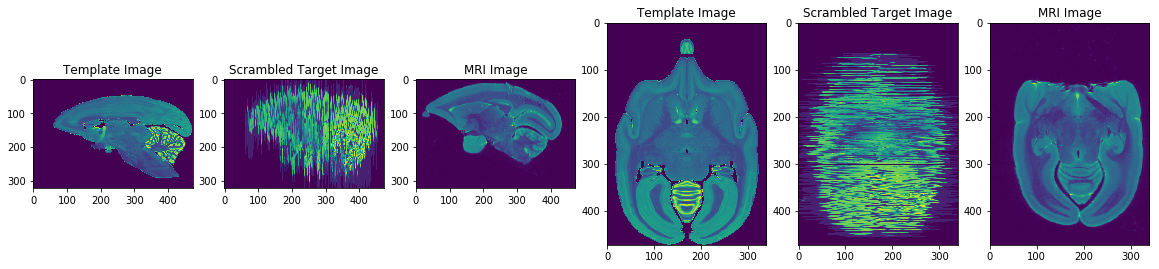

In [4]:
a = torch.Tensor(3.0*(np.random.rand(target_image.shape[1],1)-0.5)).type(torch.FloatTensor).to(device=device)
b = torch.Tensor(3.0*(np.random.rand(target_image.shape[1],1)-0.5)).type(torch.FloatTensor).to(device=device)
theta = torch.Tensor(1.5*(np.random.rand(target_image.shape[1],1)-0.5)).type(torch.FloatTensor).to(device=device)
outtarget = torch.transpose(lddmm.applySA(torch.Tensor(target_image).type(torch.FloatTensor).to(device=device), a, b, theta, dim=1,nx=list(target_image.shape),dx=[0.08,0.08,0.08]),2,1).cpu().numpy().astype(np.float32)

# display slices
plt.rcParams["figure.figsize"]=20,20
plt.figure()
plt.subplot(1,6,1)
plt.imshow(template_image[:,:,150])
plt.title('Template Image')
plt.subplot(1,6,2)
plt.imshow(outtarget[:,:,150])
plt.title('Scrambled Target Image')
plt.subplot(1,6,3)
plt.imshow(mri_image[:,:,150])
plt.title('MRI Image')
plt.subplot(1,6,4)
plt.imshow(template_image[150,:,:])
plt.title('Template Image')
plt.subplot(1,6,5)
plt.imshow(outtarget[150,:,:])
plt.title('Scrambled Target Image')
plt.subplot(1,6,6)
plt.imshow(mri_image[150,:,:])
plt.title('MRI Image')
plt.show()

## Do basic alignment of target to self

In [5]:
# set parameters for self alignment

# initialize the rigid transform parameters to identity
a = None # x translation
b = None # y translation
theta = None # rotation

# check if the image is missing any slices (assumes missing if the slice is all zeros)
missingslices = []
for i in range(target_image.shape[1]):
    if np.unique(target_image[:,i,:]).shape[0] < 3:
        missingslices.append(i)

# algorithmic parameters
niter = 200 # max number of iterations
slice_dim = 1 # indicate the histology slicing dimension, here the volume is sliced coronally
do_norm = 0 # don't normalize the image
sigma_atlas = 9999999.0 # 1/sigma_atlas^2 is the weight on the reference-matching term. here we match to self so we set this high as a hack
sigma_target = 50.0 # 1/sigma_target^s is the weight on the slice-to-slice matching term (the value of the sobolev term)
dx = [0.08,0.08,0.08] # voxel size
epsilonxy=4e-8 # gradient descent step size for translation
epsilontheta=2e-8 # gradient descent step size for rotation


In [6]:


a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(torch.tensor(target_image).type(torch.FloatTensor).to(device=device),torch.tensor(mri_image).type(torch.FloatTensor).to(device=device),niter=niter,dim=slice_dim,norm=do_norm,missingslices=missingslices,sigma_atlas=sigma_atlas,sigma_target=sigma_target,a=a,b=b,theta=theta,nx=list(target_image.shape),dx=dx,epsilonxy=epsilonxy, epsilontheta=epsilontheta)

iter: 1, E= 67207.273, Eim_t= 67207.273, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 67187.797, Eim_t= 67187.797, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 3, E= 67044.055, Eim_t= 67044.055, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 4, E= 67034.414, Eim_t= 67034.414, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 5, E= 67026.609, Eim_t= 67026.609, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 6, E= 67016.695, Eim_t= 67016.695, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 7, E= 66965.547, Eim_t= 66965.547, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 8, E= 66956.875, Eim_t= 66956.875, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 9, E= 66964.80

iter: 67, E= 66738.906, Eim_t= 66738.906, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 68, E= 66735.000, Eim_t= 66735.000, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 69, E= 66735.094, Eim_t= 66735.094, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 70, E= 66731.031, Eim_t= 66731.031, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 71, E= 66729.039, Eim_t= 66729.039, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 72, E= 66725.477, Eim_t= 66725.477, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 73, E= 66722.305, Eim_t= 66722.305, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 74, E= 66719.258, Eim_t= 66719.258, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.


iter: 133, E= 66592.258, Eim_t= 66592.258, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 134, E= 66587.883, Eim_t= 66587.883, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 135, E= 66586.906, Eim_t= 66586.906, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 136, E= 66582.469, Eim_t= 66582.469, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 137, E= 66581.484, Eim_t= 66581.484, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 138, E= 66576.984, Eim_t= 66576.984, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 139, E= 66576.000, Eim_t= 66576.000, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 140, E= 66571.406, Eim_t= 66571.406, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 199, E= 66468.031, Eim_t= 66468.031, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.


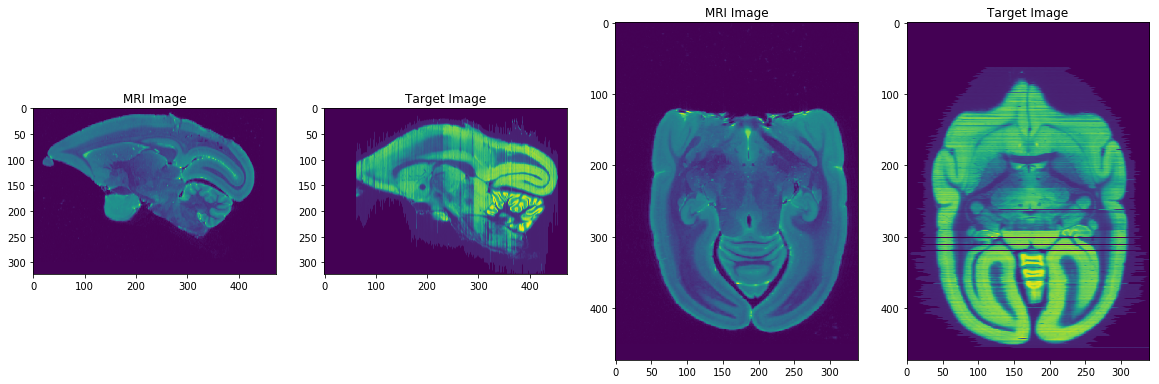

In [7]:
outtarget_np = torch.transpose(outtarget,2,1).cpu().numpy()

plt.figure()
plt.subplot(1,4,1)
plt.imshow(mri_image[:,:,150])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(torch.transpose(outtarget,2,1)[:,:,150].cpu().numpy())
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(mri_image[150,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(torch.transpose(outtarget,2,1)[150,:,:].cpu().numpy())
plt.title('Target Image')
plt.show()

## Rigidly align MRI to target

In [8]:
# set rigid alignment parameters
costmask = None # no cost function masking
outdir='../notebook/' # output directory if you choose to save data
do_affine = 2 # turns on rigid registration
do_lddmm = 0 # turns off deformable registration
niter = 150 # number of iterations
epsilonL=1e-99 # rotation gradient descent step size - set small in first step for translation-only
epsilonT=2e-05 # translation gradient descent step size
sigma=[20.0] # matching term coefficient
optimizer='gdr' # optimizer
cc=1 # turn on linear contrast correction for cross-modal matching
update_epsilon=0 # don't scale epsilon for each run


In [9]:
lddmm = torch_lddmm.LDDMM(template=[mri_image],target=[outtarget_np],costmask=costmask,outdir=outdir,do_affine=do_affine,do_lddmm=do_lddmm,niter=niter,epsilonL=epsilonL,epsilonT=epsilonT,sigma=sigma,optimizer=optimizer,dx=dx,cc=cc,update_epsilon=update_epsilon)


Current parameters:
>    a               = 5.0 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-99 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 1.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (index of C

In [10]:
lddmm.run()

iter: 0, E = 62483.7422, ER = 0.0000, EM = 62483.7422, epd = 0.005000.
iter: 1, E= 60792.855, ER= 0.000, EM= 60792.855, epd= 0.005, time= 1.63s.
iter: 2, E= 58953.398, ER= 0.000, EM= 58953.398, epd= 0.005, time= 1.59s.
iter: 3, E= 56895.734, ER= 0.000, EM= 56895.734, epd= 0.005, time= 1.61s.
iter: 4, E= 54585.117, ER= 0.000, EM= 54585.117, epd= 0.005, time= 1.59s.
iter: 5, E= 51980.016, ER= 0.000, EM= 51980.016, epd= 0.005, time= 1.61s.
iter: 6, E= 48962.375, ER= 0.000, EM= 48962.375, epd= 0.005, time= 1.58s.
iter: 7, E= 45732.527, ER= 0.000, EM= 45732.527, epd= 0.005, time= 1.61s.
iter: 8, E= 42236.828, ER= 0.000, EM= 42236.828, epd= 0.005, time= 1.58s.
iter: 9, E= 38945.520, ER= 0.000, EM= 38945.520, epd= 0.005, time= 1.60s.
iter: 10, E= 35975.488, ER= 0.000, EM= 35975.488, epd= 0.005, time= 1.58s.
iter: 11, E= 33311.875, ER= 0.000, EM= 33311.875, epd= 0.005, time= 1.61s.
iter: 12, E= 31149.617, ER= 0.000, EM= 31149.617, epd= 0.005, time= 1.59s.
iter: 13, E= 29941.412, ER= 0.000, EM=

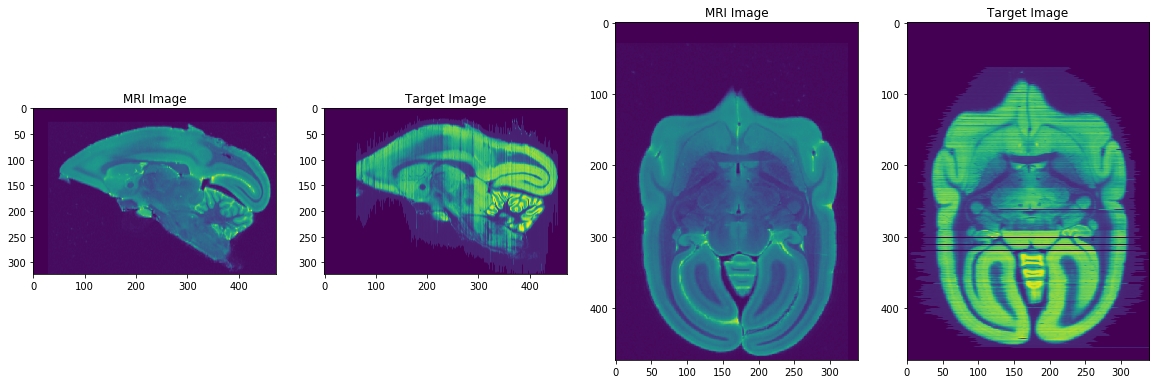

In [11]:
# apply the contrast adjustment to the MRI
mri_adjusted = (mri_image - lddmm.ccIbar[0].cpu().numpy()) * lddmm.ccCovIJ[0].cpu().numpy() / lddmm.ccVarI[0].cpu().numpy() + lddmm.ccJbar[0].cpu().numpy()
deformed_mri = (lddmm.applyThisTransform(mri_adjusted))[0][-1].cpu().numpy()

plt.figure()
plt.subplot(1,4,1)
plt.imshow(deformed_mri[:,:,150])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(outtarget_np[:,:,150])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(deformed_mri[150,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(outtarget_np[150,:,:])
plt.title('Target Image')
plt.show()

In [12]:
lddmm.setParams('epsilonL',2e-7) # turn on rotation
lddmm.setParams('epsilonT',5e-8) # keep translation on
lddmm.run()

Parameter 'epsilonL' changed to '2e-07'.
Parameter 'epsilonT' changed to '5e-08'.
iter: 0, E = 27116.8691, ER = 0.0000, EM = 27116.8691, epd = 0.005000.
iter: 1, E= 26758.680, ER= 0.000, EM= 26758.680, epd= 0.005, time= 1.57s.
iter: 2, E= 26447.125, ER= 0.000, EM= 26447.125, epd= 0.005, time= 1.59s.
iter: 3, E= 26224.711, ER= 0.000, EM= 26224.711, epd= 0.005, time= 1.58s.
iter: 4, E= 26084.830, ER= 0.000, EM= 26084.830, epd= 0.005, time= 1.60s.
iter: 5, E= 25995.320, ER= 0.000, EM= 25995.320, epd= 0.005, time= 1.58s.
iter: 6, E= 25936.799, ER= 0.000, EM= 25936.799, epd= 0.005, time= 1.60s.
iter: 7, E= 25898.479, ER= 0.000, EM= 25898.479, epd= 0.005, time= 1.58s.
iter: 8, E= 25874.154, ER= 0.000, EM= 25874.154, epd= 0.005, time= 1.60s.
iter: 9, E= 25858.816, ER= 0.000, EM= 25858.816, epd= 0.005, time= 1.58s.
iter: 10, E= 25848.902, ER= 0.000, EM= 25848.902, epd= 0.005, time= 1.59s.
iter: 11, E= 25842.361, ER= 0.000, EM= 25842.361, epd= 0.005, time= 1.58s.
iter: 12, E= 25838.000, ER= 0.0

In [13]:
lddmm.setParams('do_affine',1) # do affine matching (adding shear and scaling)
lddmm.run()

Parameter 'do_affine' changed to '1'.
iter: 0, E = 25830.2012, ER = 0.0000, EM = 25830.2012, epd = 0.005000.
iter: 1, E= 24546.295, ER= 0.000, EM= 24546.295, epd= 0.005, time= 1.58s.
iter: 2, E= 24058.916, ER= 0.000, EM= 24058.916, epd= 0.005, time= 1.57s.
iter: 3, E= 23850.021, ER= 0.000, EM= 23850.021, epd= 0.005, time= 1.57s.
iter: 4, E= 23727.164, ER= 0.000, EM= 23727.164, epd= 0.005, time= 1.58s.
iter: 5, E= 23637.424, ER= 0.000, EM= 23637.424, epd= 0.005, time= 1.58s.
iter: 6, E= 23565.729, ER= 0.000, EM= 23565.729, epd= 0.005, time= 1.57s.
iter: 7, E= 23503.156, ER= 0.000, EM= 23503.156, epd= 0.005, time= 1.57s.
iter: 8, E= 23448.188, ER= 0.000, EM= 23448.188, epd= 0.005, time= 1.58s.
iter: 9, E= 23398.465, ER= 0.000, EM= 23398.465, epd= 0.005, time= 1.58s.
iter: 10, E= 23352.600, ER= 0.000, EM= 23352.600, epd= 0.005, time= 1.58s.
iter: 11, E= 23309.473, ER= 0.000, EM= 23309.473, epd= 0.005, time= 1.58s.
iter: 12, E= 23269.031, ER= 0.000, EM= 23269.031, epd= 0.005, time= 1.58s.


iter: 108, E= 22515.918, ER= 0.000, EM= 22515.918, epd= 0.005, time= 1.58s.
iter: 109, E= 22514.689, ER= 0.000, EM= 22514.689, epd= 0.005, time= 1.58s.
iter: 110, E= 22513.469, ER= 0.000, EM= 22513.469, epd= 0.005, time= 1.58s.
iter: 111, E= 22512.252, ER= 0.000, EM= 22512.252, epd= 0.005, time= 1.58s.
iter: 112, E= 22511.035, ER= 0.000, EM= 22511.035, epd= 0.005, time= 1.58s.
iter: 113, E= 22509.832, ER= 0.000, EM= 22509.832, epd= 0.005, time= 1.58s.
iter: 114, E= 22508.633, ER= 0.000, EM= 22508.633, epd= 0.005, time= 1.58s.
iter: 115, E= 22507.439, ER= 0.000, EM= 22507.439, epd= 0.005, time= 1.57s.
iter: 116, E= 22506.254, ER= 0.000, EM= 22506.254, epd= 0.005, time= 1.58s.
iter: 117, E= 22505.072, ER= 0.000, EM= 22505.072, epd= 0.005, time= 1.57s.
iter: 118, E= 22503.895, ER= 0.000, EM= 22503.895, epd= 0.005, time= 1.58s.
iter: 119, E= 22502.730, ER= 0.000, EM= 22502.730, epd= 0.005, time= 1.58s.
iter: 120, E= 22501.562, ER= 0.000, EM= 22501.562, epd= 0.005, time= 1.58s.
iter: 121, E

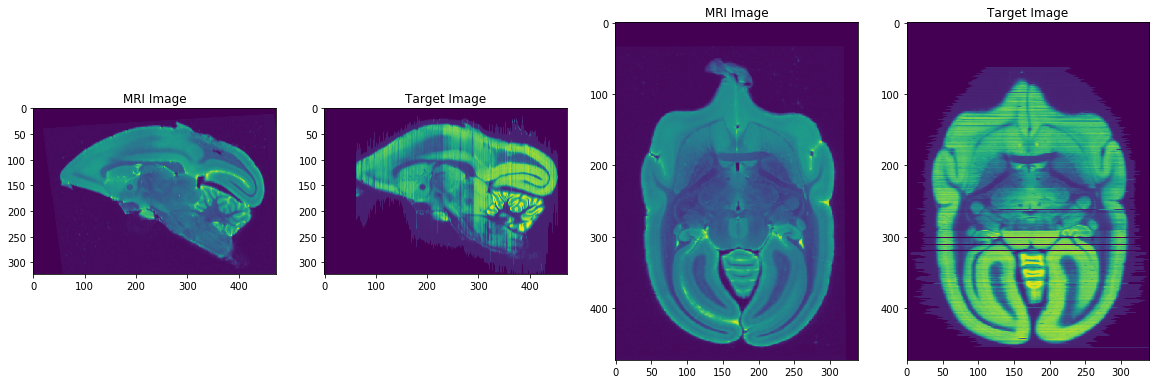

In [14]:
# apply the contrast adjustment to the MRI
mri_adjusted = (mri_image - lddmm.ccIbar[0].cpu().numpy()) * lddmm.ccCovIJ[0].cpu().numpy() / lddmm.ccVarI[0].cpu().numpy() + lddmm.ccJbar[0].cpu().numpy()
deformed_mri = (lddmm.applyThisTransform(mri_adjusted))[0][-1].cpu().numpy()

plt.figure()
plt.subplot(1,4,1)
plt.imshow(deformed_mri[:,:,150])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(outtarget_np[:,:,150])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(deformed_mri[150,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(outtarget_np[150,:,:])
plt.title('Target Image')
plt.show()

## Do section alignment to MRI

In [15]:
# check again for missing slices
missingslices = []
for i in range(target_image.shape[1]):
    if np.unique(target_image[:,i,:]).shape[0] < 3:
        missingslices.append(i)


# set transformation parameters to identity
a = None
b = None
theta = None

# set gradient descent step size - other parameters are still being used from the affine registration above
epsilonxy = 2e-8 # stack alignment translation
epsilontheta=1e-8 # stack alignment rotation
lddmm.setParams('epsilonL',1e-7) # MRI-to-histology rotation + shear + scale
lddmm.setParams('epsilonT',2e-8) # MRI-to-histology translation

# set weight parameters
sigma_atlas=4.0 # stack alignment reference matching weight = 1/sigma_atlas^2
sigma_target=50.0 # stack alignment slice to slice matching weight = 1/sigma_target^2
# MRI-to-target weight parameters are still active from the cell above

# loop
nepochs = 8
for i in range(1,nepochs):
    # change the number of iterations depending on the epoch number
    if i == 1:
        niter = 600
    elif i < 3:
        niter = 100
    elif i == 7:
        niter = 800
    else:
        niter = 200
    
    a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(torch.tensor(target_image).type(torch.FloatTensor).cuda(),torch.tensor(deformed_mri).type(torch.FloatTensor).cuda(),niter=niter,dim=slice_dim,norm=do_norm,missingslices=missingslices,sigma_atlas=sigma_atlas,sigma_target=sigma_target,a=a,b=b,theta=theta,nx=list(target_image.shape),dx=dx,epsilonxy=epsilonxy*4, epsilontheta=epsilontheta*4)
    outtarget = torch.transpose(lddmm.applySA(torch.tensor(target_image).type(torch.FloatTensor).cuda(), a, b, theta, dim=slice_dim,nx=list(target_image.shape),dx=dx),2,slice_dim).cpu().numpy().astype(np.float32)
    lddmm.setParams('energy_fraction_from',len(lddmm.EAll)-1)
    
    if i < nepochs:
        lddmm.J[0] = torch.tensor(outtarget).type(torch.FloatTensor).cuda()
        lddmm.setParams('niter',40)
        lddmm.run()
    
    # resample the mri image
    deformed_mri = (lddmm.applyThisTransform(mri_adjusted))[0][-1].cpu().numpy()

Parameter 'epsilonL' changed to '1e-07'.
Parameter 'epsilonT' changed to '2e-08'.
iter: 1, E= 538533.188, Eim_t= 67207.273, Eim_a= 471325.906, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 536587.062, Eim_t= 66962.766, Eim_a= 469624.312, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 3, E= 532703.750, Eim_t= 66283.469, Eim_a= 466420.312, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 4, E= 531200.625, Eim_t= 66169.492, Eim_a= 465031.125, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 5, E= 529184.562, Eim_t= 66169.344, Eim_a= 463015.219, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 6, E= 527705.500, Eim_t= 66068.891, Eim_a= 461636.594, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 7, E= 529757.750, Eim_t= 69218.562, Eim_a= 460539.219, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 8, E= 528110.1

iter: 64, E= 467162.125, Eim_t= 65431.340, Eim_a= 401730.781, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 65, E= 467055.125, Eim_t= 65391.719, Eim_a= 401663.406, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 66, E= 464753.344, Eim_t= 65385.469, Eim_a= 399367.875, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 67, E= 464657.344, Eim_t= 65371.594, Eim_a= 399285.750, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 68, E= 462263.750, Eim_t= 65344.176, Eim_a= 396919.562, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 69, E= 462193.969, Eim_t= 65340.473, Eim_a= 396853.500, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 70, E= 459809.406, Eim_t= 65318.492, Eim_a= 394490.906, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 71, E= 459747.938, Eim_t= 65322.590, Eim_a= 394425.344, ER_xy= 0.000, ER_t= 0

iter: 127, E= 419272.375, Eim_t= 65645.672, Eim_a= 353626.688, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 128, E= 418850.688, Eim_t= 65618.453, Eim_a= 353232.250, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 129, E= 418815.906, Eim_t= 65603.156, Eim_a= 353212.750, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 130, E= 418420.250, Eim_t= 65592.164, Eim_a= 352828.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 131, E= 418402.500, Eim_t= 65588.164, Eim_a= 352814.344, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 132, E= 418020.062, Eim_t= 65587.984, Eim_a= 352432.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 133, E= 418003.000, Eim_t= 65587.453, Eim_a= 352415.531, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 134, E= 417629.938, Eim_t= 65589.672, Eim_a= 352040.250, ER_xy= 0.000,

iter: 190, E= 411295.156, Eim_t= 65706.055, Eim_a= 345589.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 191, E= 411291.031, Eim_t= 65706.602, Eim_a= 345584.438, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 192, E= 411154.812, Eim_t= 65736.562, Eim_a= 345418.250, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 193, E= 411151.312, Eim_t= 65738.578, Eim_a= 345412.719, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 194, E= 411066.750, Eim_t= 65815.570, Eim_a= 345251.188, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 195, E= 411066.844, Eim_t= 65820.656, Eim_a= 345246.188, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 196, E= 411167.000, Eim_t= 66080.891, Eim_a= 345086.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 197, E= 411151.906, Eim_t= 66072.039, Eim_a= 345079.875, ER_xy= 0.000,

iter: 253, E= 408272.625, Eim_t= 65964.367, Eim_a= 342308.250, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 254, E= 408340.562, Eim_t= 66103.922, Eim_a= 342236.656, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 255, E= 408337.125, Eim_t= 66104.453, Eim_a= 342232.656, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 256, E= 408014.438, Eim_t= 65850.500, Eim_a= 342163.938, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 257, E= 408018.000, Eim_t= 65859.422, Eim_a= 342158.562, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 258, E= 407894.094, Eim_t= 65792.312, Eim_a= 342101.781, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 259, E= 407860.750, Eim_t= 65761.008, Eim_a= 342099.750, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 260, E= 407782.812, Eim_t= 65743.469, Eim_a= 342039.344, ER_xy= 0.000,

iter: 316, E= 406105.875, Eim_t= 65759.672, Eim_a= 340346.219, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 317, E= 406104.625, Eim_t= 65759.734, Eim_a= 340344.875, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 318, E= 406055.500, Eim_t= 65761.008, Eim_a= 340294.500, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 319, E= 406054.312, Eim_t= 65761.016, Eim_a= 340293.312, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 320, E= 406004.875, Eim_t= 65764.047, Eim_a= 340240.844, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 321, E= 406003.562, Eim_t= 65764.109, Eim_a= 340239.438, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 322, E= 405954.000, Eim_t= 65767.391, Eim_a= 340186.625, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 323, E= 405952.781, Eim_t= 65767.414, Eim_a= 340185.375, ER_xy= 0.000,

iter: 379, E= 404855.375, Eim_t= 65839.328, Eim_a= 339016.062, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 380, E= 404813.750, Eim_t= 65829.703, Eim_a= 338984.031, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 381, E= 404810.000, Eim_t= 65827.477, Eim_a= 338982.531, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 382, E= 404776.750, Eim_t= 65823.797, Eim_a= 338952.969, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 383, E= 404774.219, Eim_t= 65822.258, Eim_a= 338951.969, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 384, E= 404748.125, Eim_t= 65829.008, Eim_a= 338919.125, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 385, E= 404745.625, Eim_t= 65827.984, Eim_a= 338917.656, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 386, E= 404726.812, Eim_t= 65839.500, Eim_a= 338887.312, ER_xy= 0.000,

iter: 442, E= 403922.938, Eim_t= 65817.023, Eim_a= 338105.906, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 443, E= 403913.250, Eim_t= 65808.047, Eim_a= 338105.219, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 444, E= 403885.688, Eim_t= 65801.266, Eim_a= 338084.406, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 445, E= 403883.281, Eim_t= 65800.031, Eim_a= 338083.250, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 446, E= 403860.188, Eim_t= 65796.633, Eim_a= 338063.562, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 447, E= 403859.062, Eim_t= 65796.141, Eim_a= 338062.938, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 448, E= 403837.500, Eim_t= 65795.977, Eim_a= 338041.531, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 449, E= 403836.375, Eim_t= 65795.766, Eim_a= 338040.625, ER_xy= 0.000,

iter: 505, E= 403277.656, Eim_t= 65810.570, Eim_a= 337467.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 506, E= 403268.750, Eim_t= 65820.328, Eim_a= 337448.438, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 507, E= 403268.156, Eim_t= 65820.461, Eim_a= 337447.688, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 508, E= 403276.250, Eim_t= 65849.023, Eim_a= 337427.219, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 509, E= 403275.406, Eim_t= 65849.875, Eim_a= 337425.531, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 510, E= 403236.438, Eim_t= 65824.172, Eim_a= 337412.250, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 511, E= 403237.719, Eim_t= 65826.062, Eim_a= 337411.656, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 512, E= 403214.250, Eim_t= 65817.812, Eim_a= 337396.438, ER_xy= 0.000,

iter: 568, E= 402775.000, Eim_t= 65809.859, Eim_a= 336965.125, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 569, E= 402773.875, Eim_t= 65809.734, Eim_a= 336964.156, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.56.
iter: 570, E= 402762.000, Eim_t= 65811.539, Eim_a= 336950.469, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 571, E= 402761.125, Eim_t= 65811.391, Eim_a= 336949.750, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 572, E= 402751.969, Eim_t= 65817.336, Eim_a= 336934.625, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 573, E= 402750.812, Eim_t= 65817.320, Eim_a= 336933.500, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 574, E= 402747.250, Eim_t= 65827.469, Eim_a= 336919.781, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 575, E= 402746.562, Eim_t= 65827.539, Eim_a= 336919.031, ER_xy= 0.000,

iter: 8, E= 404788.844, Eim_t= 77892.539, Eim_a= 326896.312, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 9, E= 411072.312, Eim_t= 83941.094, Eim_a= 327131.219, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 10, E= 408163.250, Eim_t= 81240.266, Eim_a= 326923.000, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 11, E= 401956.062, Eim_t= 75466.766, Eim_a= 326489.281, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 12, E= 402069.688, Eim_t= 75646.609, Eim_a= 326423.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 13, E= 402635.062, Eim_t= 76245.727, Eim_a= 326389.344, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 14, E= 396444.250, Eim_t= 70463.414, Eim_a= 325980.844, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 15, E= 395565.156, Eim_t= 69654.023, Eim_a= 325911.125, ER_xy= 0.000, ER_t= 0.0

iter: 71, E= 390681.750, Eim_t= 65777.359, Eim_a= 324904.406, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 72, E= 390669.062, Eim_t= 65777.070, Eim_a= 324892.000, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 73, E= 390667.625, Eim_t= 65776.664, Eim_a= 324890.969, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 74, E= 390655.688, Eim_t= 65776.430, Eim_a= 324879.250, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 75, E= 390654.531, Eim_t= 65776.312, Eim_a= 324878.219, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 76, E= 390643.281, Eim_t= 65777.711, Eim_a= 324865.562, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 77, E= 390642.062, Eim_t= 65777.578, Eim_a= 324864.500, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 78, E= 390630.750, Eim_t= 65778.359, Eim_a= 324852.406, ER_xy= 0.000, ER_t= 0

iter: 11, E= 412329.625, Eim_t= 88810.367, Eim_a= 323519.250, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.56.
iter: 12, E= 399409.906, Eim_t= 76777.930, Eim_a= 322631.969, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.56.
iter: 13, E= 401575.438, Eim_t= 79002.508, Eim_a= 322572.938, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 14, E= 400829.469, Eim_t= 78113.742, Eim_a= 322715.719, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 15, E= 398284.062, Eim_t= 75849.062, Eim_a= 322435.000, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 16, E= 400780.062, Eim_t= 78126.102, Eim_a= 322653.969, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 17, E= 399963.188, Eim_t= 77479.359, Eim_a= 322483.844, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 18, E= 391618.750, Eim_t= 69555.047, Eim_a= 322063.688, ER_xy= 0.000, ER_t= 0

iter: 74, E= 387274.125, Eim_t= 65775.953, Eim_a= 321498.188, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 75, E= 387273.312, Eim_t= 65776.016, Eim_a= 321497.312, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.56.
iter: 76, E= 387263.719, Eim_t= 65772.820, Eim_a= 321490.906, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 77, E= 387263.656, Eim_t= 65773.500, Eim_a= 321490.156, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 78, E= 387256.281, Eim_t= 65771.836, Eim_a= 321484.438, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 79, E= 387256.375, Eim_t= 65772.727, Eim_a= 321483.656, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 80, E= 387249.531, Eim_t= 65772.242, Eim_a= 321477.281, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 81, E= 387247.469, Eim_t= 65770.719, Eim_a= 321476.750, ER_xy= 0.000, ER_t= 0

iter: 137, E= 387059.625, Eim_t= 65778.383, Eim_a= 321281.250, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 138, E= 387054.062, Eim_t= 65778.844, Eim_a= 321275.219, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 139, E= 387053.594, Eim_t= 65778.812, Eim_a= 321274.781, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 140, E= 387047.875, Eim_t= 65779.422, Eim_a= 321268.469, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 141, E= 387047.375, Eim_t= 65779.398, Eim_a= 321267.969, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 142, E= 387041.469, Eim_t= 65779.875, Eim_a= 321261.594, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 143, E= 387040.875, Eim_t= 65779.844, Eim_a= 321261.031, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 144, E= 387034.875, Eim_t= 65780.547, Eim_a= 321254.344, ER_xy= 0.000,

Parameter 'energy_fraction_from' changed to '329'.
Parameter 'niter' changed to '40'.
iter: 0, E = 16596.2852, ER = 0.0000, EM = 16596.2852, epd = 0.005000.
iter: 1, E= 16575.549, ER= 0.000, EM= 16575.549, epd= 0.005, time= 1.58s.
iter: 2, E= 16571.709, ER= 0.000, EM= 16571.709, epd= 0.005, time= 1.58s.
iter: 3, E= 16569.639, ER= 0.000, EM= 16569.639, epd= 0.005, time= 1.58s.
iter: 4, E= 16568.160, ER= 0.000, EM= 16568.160, epd= 0.005, time= 1.57s.
iter: 5, E= 16566.918, ER= 0.000, EM= 16566.918, epd= 0.005, time= 1.58s.
iter: 6, E= 16565.791, ER= 0.000, EM= 16565.791, epd= 0.005, time= 1.58s.
iter: 7, E= 16564.719, ER= 0.000, EM= 16564.719, epd= 0.005, time= 1.58s.
iter: 8, E= 16563.686, ER= 0.000, EM= 16563.686, epd= 0.005, time= 1.57s.
iter: 9, E= 16562.664, ER= 0.000, EM= 16562.664, epd= 0.005, time= 1.58s.
iter: 10, E= 16561.664, ER= 0.000, EM= 16561.664, epd= 0.005, time= 1.58s.
iter: 11, E= 16560.674, ER= 0.000, EM= 16560.674, epd= 0.005, time= 1.58s.
iter: 12, E= 16559.688, ER=

iter: 40, E= 385605.000, Eim_t= 65782.453, Eim_a= 319822.531, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iter: 41, E= 385604.594, Eim_t= 65782.430, Eim_a= 319822.156, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 42, E= 385600.062, Eim_t= 65782.680, Eim_a= 319817.375, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 43, E= 385599.719, Eim_t= 65782.664, Eim_a= 319817.062, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 44, E= 385595.031, Eim_t= 65782.750, Eim_a= 319812.281, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iter: 45, E= 385594.625, Eim_t= 65782.734, Eim_a= 319811.875, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 46, E= 385590.000, Eim_t= 65783.031, Eim_a= 319806.969, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iter: 47, E= 385589.562, Eim_t= 65783.016, Eim_a= 319806.562, ER_xy= 0.000, ER_t= 0

iter: 103, E= 385471.938, Eim_t= 65791.828, Eim_a= 319680.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 104, E= 385468.031, Eim_t= 65792.055, Eim_a= 319675.969, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 105, E= 385467.656, Eim_t= 65792.094, Eim_a= 319675.562, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 106, E= 385463.844, Eim_t= 65792.742, Eim_a= 319671.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 107, E= 385463.562, Eim_t= 65792.828, Eim_a= 319670.719, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 108, E= 385459.562, Eim_t= 65793.180, Eim_a= 319666.375, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 109, E= 385459.281, Eim_t= 65793.273, Eim_a= 319666.000, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.56.
iter: 110, E= 385456.812, Eim_t= 65795.625, Eim_a= 319661.188, ER_xy= 0.000,

iter: 166, E= 385367.406, Eim_t= 65802.648, Eim_a= 319564.750, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 167, E= 385367.125, Eim_t= 65802.742, Eim_a= 319564.375, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 168, E= 385366.438, Eim_t= 65804.336, Eim_a= 319562.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 169, E= 385366.125, Eim_t= 65804.352, Eim_a= 319561.781, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 170, E= 385370.250, Eim_t= 65812.359, Eim_a= 319557.906, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 171, E= 385370.156, Eim_t= 65812.742, Eim_a= 319557.406, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 172, E= 385359.719, Eim_t= 65803.977, Eim_a= 319555.750, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 173, E= 385359.938, Eim_t= 65804.438, Eim_a= 319555.500, ER_xy= 0.000,

iter: 6, E= 398119.500, Eim_t= 78391.195, Eim_a= 319728.312, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 7, E= 397823.500, Eim_t= 78193.703, Eim_a= 319629.781, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 8, E= 407001.781, Eim_t= 86560.438, Eim_a= 320441.344, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 9, E= 406189.062, Eim_t= 85941.406, Eim_a= 320247.656, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 10, E= 390722.125, Eim_t= 71561.008, Eim_a= 319161.125, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 11, E= 391750.688, Eim_t= 72655.094, Eim_a= 319095.594, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 12, E= 390848.688, Eim_t= 71684.508, Eim_a= 319164.188, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 13, E= 389409.719, Eim_t= 70390.008, Eim_a= 319019.719, ER_xy= 0.000, ER_t= 0.000

iter: 69, E= 384491.250, Eim_t= 65806.586, Eim_a= 318684.656, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 70, E= 384490.750, Eim_t= 65809.578, Eim_a= 318681.188, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 71, E= 384490.375, Eim_t= 65809.648, Eim_a= 318680.719, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 72, E= 384492.750, Eim_t= 65814.141, Eim_a= 318678.625, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 73, E= 384494.281, Eim_t= 65815.688, Eim_a= 318678.594, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.57.
iter: 74, E= 384494.438, Eim_t= 65819.008, Eim_a= 318675.438, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 75, E= 384492.406, Eim_t= 65817.562, Eim_a= 318674.844, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 76, E= 384482.375, Eim_t= 65808.664, Eim_a= 318673.719, ER_xy= 0.000, ER_t= 0

iter: 132, E= 384423.062, Eim_t= 65810.539, Eim_a= 318612.531, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 133, E= 384422.906, Eim_t= 65810.523, Eim_a= 318612.375, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 134, E= 384421.438, Eim_t= 65810.656, Eim_a= 318610.781, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 135, E= 384421.250, Eim_t= 65810.633, Eim_a= 318610.625, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 136, E= 384419.750, Eim_t= 65810.711, Eim_a= 318609.031, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 137, E= 384419.562, Eim_t= 65810.711, Eim_a= 318608.844, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 138, E= 384417.969, Eim_t= 65810.836, Eim_a= 318607.125, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 139, E= 384417.781, Eim_t= 65810.820, Eim_a= 318606.969, ER_xy= 0.000,

iter: 195, E= 384363.781, Eim_t= 65812.992, Eim_a= 318550.781, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 196, E= 384361.938, Eim_t= 65812.922, Eim_a= 318549.000, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 197, E= 384361.688, Eim_t= 65812.922, Eim_a= 318548.781, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 198, E= 384360.219, Eim_t= 65813.477, Eim_a= 318546.750, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 199, E= 384359.938, Eim_t= 65813.469, Eim_a= 318546.469, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.56.
Parameter 'energy_fraction_from' changed to '409'.
Parameter 'niter' changed to '40'.
iter: 0, E = 16393.3047, ER = 0.0000, EM = 16393.3047, epd = 0.005000.
iter: 1, E= 16390.830, ER= 0.000, EM= 16390.830, epd= 0.005, time= 1.58s.
iter: 2, E= 16389.641, ER= 0.000, EM= 16389.641, epd= 0.005, time= 1.58s.
iter: 3, E= 16388.619, ER= 0.000, E

iter: 35, E= 383717.562, Eim_t= 65844.094, Eim_a= 317873.469, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 36, E= 383701.969, Eim_t= 65830.898, Eim_a= 317871.062, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 37, E= 383697.344, Eim_t= 65827.242, Eim_a= 317870.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 38, E= 383690.781, Eim_t= 65821.695, Eim_a= 317869.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 39, E= 383691.125, Eim_t= 65821.641, Eim_a= 317869.469, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.56.
iter: 40, E= 383687.625, Eim_t= 65819.547, Eim_a= 317868.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 41, E= 383682.656, Eim_t= 65815.156, Eim_a= 317867.500, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.57.
iter: 42, E= 383680.844, Eim_t= 65814.477, Eim_a= 317866.375, ER_xy= 0.000, ER_t= 0

iter: 98, E= 383637.969, Eim_t= 65813.344, Eim_a= 317824.625, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 99, E= 383637.844, Eim_t= 65813.336, Eim_a= 317824.500, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 100, E= 383636.594, Eim_t= 65813.367, Eim_a= 317823.219, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 101, E= 383636.406, Eim_t= 65813.352, Eim_a= 317823.062, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 102, E= 383635.125, Eim_t= 65813.328, Eim_a= 317821.781, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 103, E= 383634.938, Eim_t= 65813.320, Eim_a= 317821.625, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 104, E= 383633.625, Eim_t= 65813.359, Eim_a= 317820.250, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 105, E= 383633.438, Eim_t= 65813.344, Eim_a= 317820.094, ER_xy= 0.000, E

iter: 161, E= 383594.938, Eim_t= 65815.734, Eim_a= 317779.219, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 162, E= 383592.750, Eim_t= 65814.188, Eim_a= 317778.562, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 163, E= 383593.031, Eim_t= 65814.570, Eim_a= 317778.469, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 164, E= 383592.094, Eim_t= 65814.945, Eim_a= 317777.156, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 165, E= 383591.375, Eim_t= 65814.453, Eim_a= 317776.906, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.57.
iter: 166, E= 383589.688, Eim_t= 65813.602, Eim_a= 317776.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 167, E= 383589.500, Eim_t= 65813.492, Eim_a= 317776.000, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 168, E= 383588.844, Eim_t= 65814.195, Eim_a= 317774.656, ER_xy= 0.000,

iter: 1, E= 382969.188, Eim_t= 65814.734, Eim_a= 317154.469, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 383092.031, Eim_t= 65935.875, Eim_a= 317156.156, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 3, E= 383121.812, Eim_t= 65965.969, Eim_a= 317155.844, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 4, E= 386807.906, Eim_t= 69438.227, Eim_a= 317369.688, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 5, E= 387646.344, Eim_t= 70275.031, Eim_a= 317371.312, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 6, E= 407136.312, Eim_t= 88184.414, Eim_a= 318951.906, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 7, E= 406229.375, Eim_t= 87477.406, Eim_a= 318751.969, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 8, E= 402297.312, Eim_t= 83817.625, Eim_a= 318479.688, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000

iter: 64, E= 382917.344, Eim_t= 65811.094, Eim_a= 317106.250, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 65, E= 382917.156, Eim_t= 65811.055, Eim_a= 317106.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 66, E= 382916.000, Eim_t= 65810.984, Eim_a= 317105.031, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 67, E= 382915.875, Eim_t= 65810.961, Eim_a= 317104.906, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 68, E= 382914.812, Eim_t= 65810.953, Eim_a= 317103.844, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 69, E= 382914.594, Eim_t= 65810.930, Eim_a= 317103.656, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 70, E= 382913.406, Eim_t= 65810.836, Eim_a= 317102.562, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 71, E= 382913.250, Eim_t= 65810.828, Eim_a= 317102.438, ER_xy= 0.000, ER_t= 0

iter: 127, E= 382886.125, Eim_t= 65813.125, Eim_a= 317073.000, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 128, E= 382886.125, Eim_t= 65813.734, Eim_a= 317072.375, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 129, E= 382885.281, Eim_t= 65813.273, Eim_a= 317072.000, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 130, E= 382884.000, Eim_t= 65812.859, Eim_a= 317071.156, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 131, E= 382884.062, Eim_t= 65812.836, Eim_a= 317071.219, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 132, E= 382884.688, Eim_t= 65814.117, Eim_a= 317070.562, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 133, E= 382883.562, Eim_t= 65813.273, Eim_a= 317070.281, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 134, E= 382879.062, Eim_t= 65809.586, Eim_a= 317069.469, ER_xy= 0.000,

iter: 190, E= 382852.062, Eim_t= 65806.859, Eim_a= 317045.219, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 191, E= 382852.000, Eim_t= 65806.852, Eim_a= 317045.156, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 192, E= 382851.438, Eim_t= 65806.867, Eim_a= 317044.562, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 193, E= 382851.312, Eim_t= 65806.844, Eim_a= 317044.469, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 194, E= 382850.500, Eim_t= 65806.711, Eim_a= 317043.781, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 195, E= 382850.406, Eim_t= 65806.711, Eim_a= 317043.688, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 196, E= 382849.812, Eim_t= 65806.734, Eim_a= 317043.062, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 197, E= 382849.625, Eim_t= 65806.711, Eim_a= 317042.906, ER_xy= 0.000,

iter: 253, E= 382827.312, Eim_t= 65805.516, Eim_a= 317021.812, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 254, E= 382826.500, Eim_t= 65805.438, Eim_a= 317021.062, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 255, E= 382826.406, Eim_t= 65805.438, Eim_a= 317020.969, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 256, E= 382825.688, Eim_t= 65805.531, Eim_a= 317020.156, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 257, E= 382825.500, Eim_t= 65805.516, Eim_a= 317020.000, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 258, E= 382824.656, Eim_t= 65805.430, Eim_a= 317019.219, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 259, E= 382824.562, Eim_t= 65805.445, Eim_a= 317019.125, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 260, E= 382824.312, Eim_t= 65806.047, Eim_a= 317018.281, ER_xy= 0.000,

iter: 316, E= 382803.031, Eim_t= 65804.758, Eim_a= 316998.281, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 317, E= 382803.250, Eim_t= 65804.836, Eim_a= 316998.406, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 318, E= 382802.625, Eim_t= 65804.641, Eim_a= 316997.969, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 319, E= 382801.875, Eim_t= 65804.117, Eim_a= 316997.750, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 320, E= 382801.250, Eim_t= 65803.883, Eim_a= 316997.375, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 321, E= 382801.219, Eim_t= 65803.906, Eim_a= 316997.312, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 322, E= 382800.781, Eim_t= 65803.914, Eim_a= 316996.875, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 323, E= 382800.688, Eim_t= 65803.898, Eim_a= 316996.781, ER_xy= 0.000,

iter: 379, E= 382782.500, Eim_t= 65802.359, Eim_a= 316980.125, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 380, E= 382781.906, Eim_t= 65802.305, Eim_a= 316979.594, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 381, E= 382781.844, Eim_t= 65802.305, Eim_a= 316979.531, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 382, E= 382781.281, Eim_t= 65802.258, Eim_a= 316979.031, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iter: 383, E= 382781.219, Eim_t= 65802.250, Eim_a= 316978.969, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 384, E= 382780.625, Eim_t= 65802.180, Eim_a= 316978.438, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 385, E= 382780.531, Eim_t= 65802.180, Eim_a= 316978.344, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 386, E= 382779.906, Eim_t= 65802.133, Eim_a= 316977.781, ER_xy= 0.000,

iter: 442, E= 382762.531, Eim_t= 65801.055, Eim_a= 316961.469, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 443, E= 382762.500, Eim_t= 65801.047, Eim_a= 316961.438, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 444, E= 382764.719, Eim_t= 65803.961, Eim_a= 316960.750, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 445, E= 382764.531, Eim_t= 65803.914, Eim_a= 316960.625, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 446, E= 382763.500, Eim_t= 65803.016, Eim_a= 316960.469, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 447, E= 382763.406, Eim_t= 65802.938, Eim_a= 316960.469, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 448, E= 382764.469, Eim_t= 65804.664, Eim_a= 316959.812, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 449, E= 382764.094, Eim_t= 65804.445, Eim_a= 316959.656, ER_xy= 0.000,

iter: 505, E= 382746.312, Eim_t= 65799.297, Eim_a= 316947.031, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 506, E= 382745.969, Eim_t= 65799.250, Eim_a= 316946.719, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 507, E= 382745.906, Eim_t= 65799.258, Eim_a= 316946.656, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 508, E= 382745.531, Eim_t= 65799.211, Eim_a= 316946.312, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iter: 509, E= 382745.469, Eim_t= 65799.211, Eim_a= 316946.250, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 510, E= 382745.094, Eim_t= 65799.164, Eim_a= 316945.938, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 511, E= 382745.000, Eim_t= 65799.164, Eim_a= 316945.844, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 512, E= 382744.562, Eim_t= 65799.109, Eim_a= 316945.469, ER_xy= 0.000,

iter: 568, E= 382729.094, Eim_t= 65798.438, Eim_a= 316930.656, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 569, E= 382729.000, Eim_t= 65798.422, Eim_a= 316930.594, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 570, E= 382729.531, Eim_t= 65799.273, Eim_a= 316930.250, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 571, E= 382729.438, Eim_t= 65799.266, Eim_a= 316930.188, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 572, E= 382727.938, Eim_t= 65798.102, Eim_a= 316929.844, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 573, E= 382727.906, Eim_t= 65798.062, Eim_a= 316929.844, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 574, E= 382727.438, Eim_t= 65797.898, Eim_a= 316929.531, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 575, E= 382727.375, Eim_t= 65797.898, Eim_a= 316929.469, ER_xy= 0.000,

iter: 631, E= 382716.125, Eim_t= 65797.070, Eim_a= 316919.062, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 632, E= 382715.750, Eim_t= 65797.047, Eim_a= 316918.719, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 633, E= 382715.688, Eim_t= 65797.047, Eim_a= 316918.656, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 634, E= 382715.375, Eim_t= 65797.023, Eim_a= 316918.344, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 635, E= 382715.312, Eim_t= 65797.031, Eim_a= 316918.281, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 636, E= 382714.906, Eim_t= 65797.008, Eim_a= 316917.906, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 637, E= 382714.875, Eim_t= 65797.016, Eim_a= 316917.844, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 638, E= 382714.438, Eim_t= 65796.969, Eim_a= 316917.469, ER_xy= 0.000,

iter: 694, E= 382703.062, Eim_t= 65796.359, Eim_a= 316906.719, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 695, E= 382703.062, Eim_t= 65796.383, Eim_a= 316906.688, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iter: 696, E= 382705.125, Eim_t= 65798.461, Eim_a= 316906.656, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 697, E= 382705.000, Eim_t= 65798.391, Eim_a= 316906.594, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 698, E= 382704.500, Eim_t= 65798.516, Eim_a= 316906.000, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 699, E= 382704.500, Eim_t= 65798.547, Eim_a= 316905.969, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 700, E= 382705.000, Eim_t= 65798.953, Eim_a= 316906.062, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 701, E= 382704.688, Eim_t= 65798.758, Eim_a= 316905.938, ER_xy= 0.000,

iter: 757, E= 382691.656, Eim_t= 65794.094, Eim_a= 316897.562, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 758, E= 382691.406, Eim_t= 65794.062, Eim_a= 316897.344, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 759, E= 382691.344, Eim_t= 65794.062, Eim_a= 316897.281, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 760, E= 382691.125, Eim_t= 65794.031, Eim_a= 316897.094, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iter: 761, E= 382691.062, Eim_t= 65794.031, Eim_a= 316897.031, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iter: 762, E= 382690.844, Eim_t= 65794.000, Eim_a= 316896.844, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iter: 763, E= 382690.812, Eim_t= 65794.000, Eim_a= 316896.812, ER_xy= 0.000, ER_t= 0.0002, ep_xy= 0.0000, ep_t= 0.0000, time= 0.56.
iter: 764, E= 382690.531, Eim_t= 65793.961, Eim_a= 316896.562, ER_xy= 0.000,

iter: 33, E= 16234.012, ER= 0.000, EM= 16234.012, epd= 0.005, time= 1.58s.
iter: 34, E= 16233.186, ER= 0.000, EM= 16233.186, epd= 0.005, time= 1.58s.
iter: 35, E= 16232.359, ER= 0.000, EM= 16232.359, epd= 0.005, time= 1.58s.
iter: 36, E= 16231.536, ER= 0.000, EM= 16231.536, epd= 0.005, time= 1.58s.
iter: 37, E= 16230.714, ER= 0.000, EM= 16230.714, epd= 0.005, time= 1.58s.
iter: 38, E= 16229.891, ER= 0.000, EM= 16229.891, epd= 0.005, time= 1.58s.
iter: 39, E= 16229.069, ER= 0.000, EM= 16229.069, epd= 0.005, time= 1.58s.
Total elapsed runtime: 61.63 seconds.


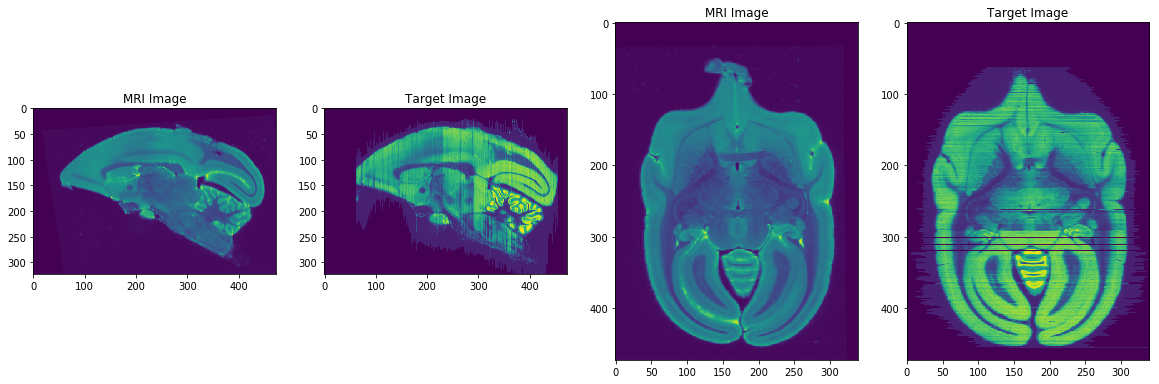

In [16]:
# apply the contrast adjustment to the MRI
mri_adjusted = (mri_image - lddmm.ccIbar[0].cpu().numpy()) * lddmm.ccCovIJ[0].cpu().numpy() / lddmm.ccVarI[0].cpu().numpy() + lddmm.ccJbar[0].cpu().numpy()

deformed_mri = (lddmm.applyThisTransform(mri_adjusted))[0][-1].cpu().numpy()

plt.figure()
plt.subplot(1,4,1)
plt.imshow(deformed_mri[:,:,150])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(outtarget[:,:,150])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(deformed_mri[150,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(outtarget[150,:,:])
plt.title('Target Image')
plt.show()

## Mapping to Brain/MINDS atlas

In [17]:
# set LDDMM parameters
costmask=None # no cost function masking
outdir='../notebook/' # output directory
do_affine=2 # rigid only alignment
do_lddmm=0 # no deformable registration
a=8 # LDDMM kernel size, in voxels
niter=150 # max iterations
epsilon=5e-3 # LDDMM gradient descent step size
epsilonL=1e-7 # linear registration gradient descent step size
epsilonT=2e-05 # translation gradient descent step size
sigma=[20.0] # matching term weight = 1/sigma^2
sigmaR=10.0 # regularization term weight = 1/sigmaR^2
optimizer='gdr' # optimizer
dx=dx # use old voxel spacing
cc=1 # linear contrast correction
update_epsilon=1 # save step sizes between runs
low_memory=0 # using a lot of gpu memory
v_scale=0.5 # half spacing for LDDMM velocity fields to save memory

In [18]:
del lddmm
torch.cuda.empty_cache()
lddmm = torch_lddmm.LDDMM(template=[template_image],target=[outtarget],costmask=costmask,outdir=outdir,do_affine=do_affine,do_lddmm=do_lddmm,a=a,niter=niter,epsilon=epsilon,epsilonL=epsilonL,epsilonT=epsilonT,sigma=sigma,sigmaR=sigmaR,optimizer=optimizer,dx=dx,cc=cc,update_epsilon=update_epsilon,low_memory=low_memory,v_scale=v_scale)


Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (index of CU

In [19]:
lddmm.run()

iter: 0, E = 46746.6836, ER = 0.0000, EM = 46746.6836, epd = 0.005000.
iter: 1, E= 44583.133, ER= 0.000, EM= 44583.133, epd= 0.005, time= 0.48s.
iter: 2, E= 44099.891, ER= 0.000, EM= 44099.891, epd= 0.005, time= 0.48s.
iter: 3, E= 43674.809, ER= 0.000, EM= 43674.809, epd= 0.005, time= 0.48s.
iter: 4, E= 43529.699, ER= 0.000, EM= 43529.699, epd= 0.005, time= 0.48s.
iter: 5, E= 43361.883, ER= 0.000, EM= 43361.883, epd= 0.005, time= 0.48s.
iter: 6, E= 42920.293, ER= 0.000, EM= 42920.293, epd= 0.005, time= 0.48s.
iter: 7, E= 42588.867, ER= 0.000, EM= 42588.867, epd= 0.005, time= 0.48s.
iter: 8, E= 42258.285, ER= 0.000, EM= 42258.285, epd= 0.005, time= 0.48s.
iter: 9, E= 42006.109, ER= 0.000, EM= 42006.109, epd= 0.005, time= 0.48s.
iter: 10, E= 41764.211, ER= 0.000, EM= 41764.211, epd= 0.005, time= 0.48s.
iter: 11, E= 41435.707, ER= 0.000, EM= 41435.707, epd= 0.005, time= 0.48s.
iter: 12, E= 41236.828, ER= 0.000, EM= 41236.828, epd= 0.005, time= 0.48s.
iter: 13, E= 41045.406, ER= 0.000, EM=

iter: 109, E= 37171.523, ER= 0.000, EM= 37171.523, epd= 0.005, time= 0.48s.
iter: 110, E= 37170.613, ER= 0.000, EM= 37170.613, epd= 0.005, time= 0.48s.
iter: 111, E= 37169.691, ER= 0.000, EM= 37169.691, epd= 0.005, time= 0.48s.
iter: 112, E= 37168.770, ER= 0.000, EM= 37168.770, epd= 0.005, time= 0.48s.
iter: 113, E= 37167.840, ER= 0.000, EM= 37167.840, epd= 0.005, time= 0.48s.
iter: 114, E= 37166.938, ER= 0.000, EM= 37166.938, epd= 0.005, time= 0.48s.
iter: 115, E= 37166.035, ER= 0.000, EM= 37166.035, epd= 0.005, time= 0.48s.
iter: 116, E= 37165.168, ER= 0.000, EM= 37165.168, epd= 0.005, time= 0.48s.
iter: 117, E= 37164.344, ER= 0.000, EM= 37164.344, epd= 0.005, time= 0.48s.
iter: 118, E= 37163.555, ER= 0.000, EM= 37163.555, epd= 0.005, time= 0.48s.
iter: 119, E= 37162.777, ER= 0.000, EM= 37162.777, epd= 0.005, time= 0.48s.
iter: 120, E= 37162.004, ER= 0.000, EM= 37162.004, epd= 0.005, time= 0.48s.
iter: 121, E= 37161.277, ER= 0.000, EM= 37161.277, epd= 0.005, time= 0.48s.
iter: 122, E

In [20]:
# turn on affine matching and continue running
lddmm.setParams('do_affine',1)
lddmm.setParams('epsilonL',1e-7)
lddmm.setParams('epsilonT',2e-5)
lddmm.run()

Parameter 'do_affine' changed to '1'.
Parameter 'epsilonL' changed to '1e-07'.
Parameter 'epsilonT' changed to '2e-05'.
iter: 0, E = 37150.9297, ER = 0.0000, EM = 37150.9297, epd = 0.005000.
iter: 1, E= 36885.398, ER= 0.000, EM= 36885.398, epd= 0.005, time= 0.48s.
iter: 2, E= 36623.039, ER= 0.000, EM= 36623.039, epd= 0.005, time= 0.48s.
iter: 3, E= 36365.113, ER= 0.000, EM= 36365.113, epd= 0.005, time= 0.48s.
iter: 4, E= 36110.254, ER= 0.000, EM= 36110.254, epd= 0.005, time= 0.48s.
iter: 5, E= 35858.609, ER= 0.000, EM= 35858.609, epd= 0.005, time= 0.48s.
iter: 6, E= 35608.633, ER= 0.000, EM= 35608.633, epd= 0.005, time= 0.48s.
iter: 7, E= 35361.250, ER= 0.000, EM= 35361.250, epd= 0.005, time= 0.48s.
iter: 8, E= 35116.438, ER= 0.000, EM= 35116.438, epd= 0.005, time= 0.49s.
iter: 9, E= 34875.711, ER= 0.000, EM= 34875.711, epd= 0.005, time= 0.48s.
iter: 10, E= 34639.672, ER= 0.000, EM= 34639.672, epd= 0.005, time= 0.48s.
iter: 11, E= 34406.113, ER= 0.000, EM= 34406.113, epd= 0.005, time= 

iter: 107, E= 26169.439, ER= 0.000, EM= 26169.439, epd= 0.005, time= 0.48s.
iter: 108, E= 26158.088, ER= 0.000, EM= 26158.088, epd= 0.005, time= 0.48s.
iter: 109, E= 26147.045, ER= 0.000, EM= 26147.045, epd= 0.005, time= 0.48s.
iter: 110, E= 26136.268, ER= 0.000, EM= 26136.268, epd= 0.005, time= 0.48s.
iter: 111, E= 26125.764, ER= 0.000, EM= 26125.764, epd= 0.005, time= 0.48s.
iter: 112, E= 26115.525, ER= 0.000, EM= 26115.525, epd= 0.005, time= 0.48s.
iter: 113, E= 26105.588, ER= 0.000, EM= 26105.588, epd= 0.005, time= 0.48s.
iter: 114, E= 26095.924, ER= 0.000, EM= 26095.924, epd= 0.005, time= 0.48s.
iter: 115, E= 26086.535, ER= 0.000, EM= 26086.535, epd= 0.005, time= 0.48s.
iter: 116, E= 26077.393, ER= 0.000, EM= 26077.393, epd= 0.005, time= 0.48s.
iter: 117, E= 26068.467, ER= 0.000, EM= 26068.467, epd= 0.005, time= 0.48s.
iter: 118, E= 26059.697, ER= 0.000, EM= 26059.697, epd= 0.005, time= 0.48s.
iter: 119, E= 26051.145, ER= 0.000, EM= 26051.145, epd= 0.005, time= 0.48s.
iter: 120, E

In [21]:
# turn on deformable matching and continue running
lddmm.setParams('do_lddmm',1)
lddmm.run()

Parameter 'do_lddmm' changed to '1'.
iter: 0, E = 25847.3535, ER = 0.0000, EM = 25847.3535, epd = 0.005000.
iter: 1, E= 24568.045, ER= 0.364, EM= 24567.682, epd= 0.003, time= 2.39s.
iter: 2, E= 23569.402, ER= 1.259, EM= 23568.143, epd= 0.003, time= 2.39s.
iter: 3, E= 22734.848, ER= 2.500, EM= 22732.348, epd= 0.003, time= 2.39s.
iter: 4, E= 22023.354, ER= 3.968, EM= 22019.385, epd= 0.003, time= 2.39s.
iter: 5, E= 21456.137, ER= 5.536, EM= 21450.600, epd= 0.003, time= 2.39s.
iter: 6, E= 21010.816, ER= 7.100, EM= 21003.717, epd= 0.003, time= 2.38s.
iter: 7, E= 20653.428, ER= 8.620, EM= 20644.807, epd= 0.003, time= 2.38s.
iter: 8, E= 20346.029, ER= 10.102, EM= 20335.928, epd= 0.003, time= 2.38s.
iter: 9, E= 20093.885, ER= 11.538, EM= 20082.346, epd= 0.003, time= 2.39s.
iter: 10, E= 19873.779, ER= 12.925, EM= 19860.855, epd= 0.003, time= 2.39s.
iter: 11, E= 19689.402, ER= 14.260, EM= 19675.143, epd= 0.003, time= 2.38s.
iter: 12, E= 19531.668, ER= 15.545, EM= 19516.123, epd= 0.003, time= 2.3

iter: 106, E= 17235.502, ER= 89.149, EM= 17146.354, epd= 0.003, time= 2.40s.
iter: 107, E= 17232.711, ER= 90.006, EM= 17142.705, epd= 0.003, time= 2.39s.
iter: 108, E= 17230.072, ER= 90.870, EM= 17139.201, epd= 0.003, time= 2.39s.
iter: 109, E= 17227.773, ER= 91.743, EM= 17136.029, epd= 0.003, time= 2.39s.
iter: 110, E= 17225.963, ER= 92.624, EM= 17133.338, epd= 0.003, time= 2.38s.
iter: 111, E= 17224.799, ER= 93.513, EM= 17131.285, epd= 0.003, time= 2.39s.
iter: 112, E= 17224.252, ER= 94.411, EM= 17129.840, epd= 0.003, time= 2.40s.
iter: 113, E= 17224.096, ER= 95.319, EM= 17128.777, epd= 0.003, time= 2.40s.
iter: 114, E= 17224.113, ER= 95.959, EM= 17128.154, epd= 0.002, time= 2.39s.
iter: 115, E= 17224.172, ER= 96.410, EM= 17127.762, epd= 0.002, time= 2.39s.
iter: 116, E= 17224.266, ER= 96.728, EM= 17127.537, epd= 0.001, time= 2.40s.
iter: 117, E= 17224.361, ER= 96.951, EM= 17127.410, epd= 0.001, time= 2.39s.
iter: 118, E= 17224.451, ER= 97.108, EM= 17127.344, epd= 0.001, time= 2.39s.

In [22]:
# reduce LDDMM kernel size and continue running
lddmm.setParams('a',5)
lddmm.run()

Parameter 'a' changed to '5'.
iter: 0, E = 17161.5176, ER = 34.2876, EM = 17127.2305, epd = 0.005000.
iter: 1, E= 17070.270, ER= 35.685, EM= 17034.584, epd= 0.005, time= 2.39s.
iter: 2, E= 16995.412, ER= 37.195, EM= 16958.217, epd= 0.005, time= 2.39s.
iter: 3, E= 16927.055, ER= 38.866, EM= 16888.189, epd= 0.005, time= 2.39s.
iter: 4, E= 16869.527, ER= 40.540, EM= 16828.988, epd= 0.005, time= 2.39s.
iter: 5, E= 16946.221, ER= 42.622, EM= 16903.598, epd= 0.005, time= 2.39s.
iter: 6, E= 17027.693, ER= 43.593, EM= 16984.100, epd= 0.003, time= 2.39s.
iter: 7, E= 16947.943, ER= 44.926, EM= 16903.018, epd= 0.002, time= 2.38s.
iter: 8, E= 16817.721, ER= 45.578, EM= 16772.143, epd= 0.002, time= 2.39s.
iter: 9, E= 16808.830, ER= 46.804, EM= 16762.025, epd= 0.002, time= 2.39s.
iter: 10, E= 16762.656, ER= 47.632, EM= 16715.025, epd= 0.002, time= 2.40s.
iter: 11, E= 16759.750, ER= 48.850, EM= 16710.900, epd= 0.002, time= 2.40s.
iter: 12, E= 16732.293, ER= 49.803, EM= 16682.490, epd= 0.002, time= 2.

/opt/intelpython3/lib/python3.6/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


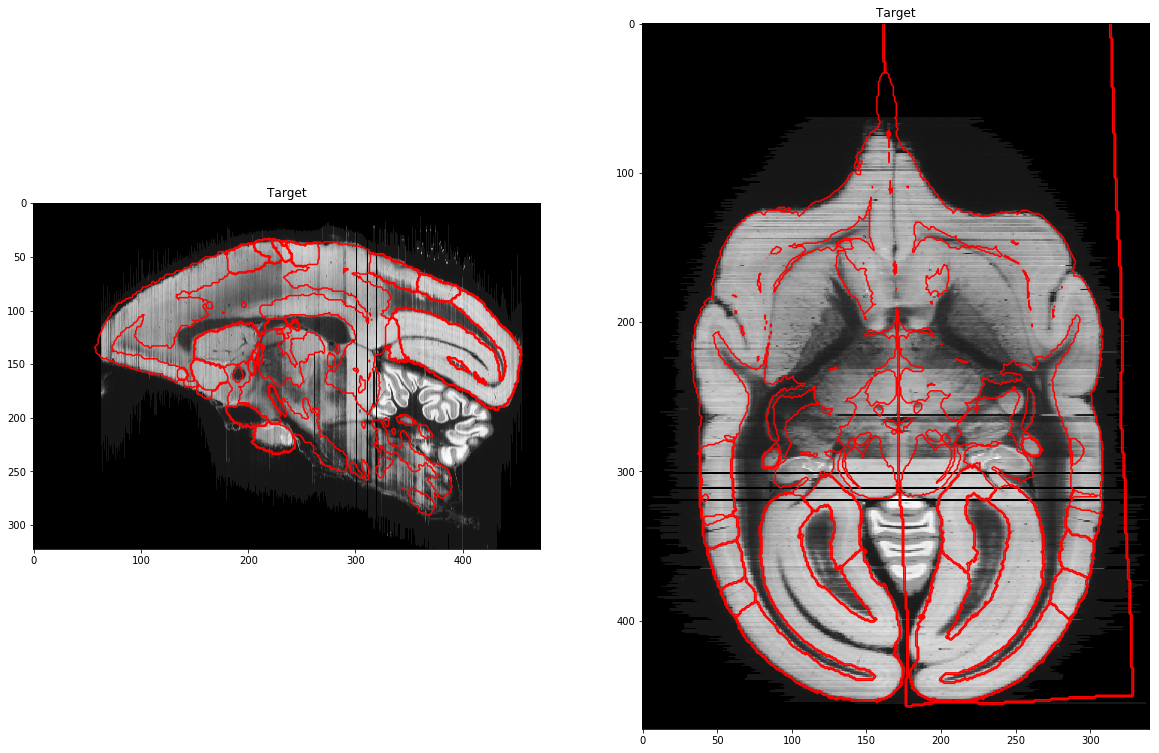

In [23]:
# transform annotation based on current transform
annotation_file_name = '../notebook/marmoset_annotation.img'
anno = nib.load(annotation_file_name).get_data().astype(np.float32)
deformed_anno,_,_,_ = lddmm.applyThisTransform(anno,interpmode='nearest')
deformed_anno = deformed_anno[-1].cpu().numpy()

# draw deformed annotation on target
levels = np.unique(deformed_anno[:,:,100])

plt.figure()
plt.subplot(1,2,1)
plt.imshow(outtarget[:,:,150],cmap='gray')
plt.title('Target')
for i in range(levels.shape[0]):
    plt.contour((deformed_anno[:,:,150]==levels[i])*1.0,0.999,colors='r')

levels = np.unique(deformed_anno[96,:,:])
plt.subplot(1,2,2)
plt.imshow(outtarget[150,:,:],cmap='gray')
plt.title('Target')
for i in range(levels.shape[0]):
    plt.contour((deformed_anno[150,:,:]==levels[i])*1.0,0.999,colors='r')

plt.show()